# Hoja de Trabajo #2
## Deep Learning y Sistemas Inteligentes

### Miembros
- Fernanda Esquivel 21542
- Melissa Pérez 21385

### Link al repositorio
El repositorio puede ser visualizado [acá](https://github.com/FerEsq/DL-HDT-02)


# Ejercicio 1

En esta actividad, implementará y comparará diferentes funciones de pérdida y técnicas de regularización
utilizando PyTorch. Utilizará el conjunto de datos de Iris para una tarea de clasificación y una arquitectura básica de
red neuronal de feedforward. El objetivo es observar cómo las diferentes opciones impactan la convergencia y el
rendimiento del modelo.

## Task 1 - Preparación del conjunto de datos

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
#Cargar el conjunto de datos de Iris
iris = load_iris()

#Convertirlo a un DataFrame de pandas para una mejor visualización
dfIris = pd.DataFrame(data=iris.data, columns=iris.feature_names)
dfIris['target'] = iris.target

#Mostrar las primeras filas del DataFrame
dfIris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
#Definir las características (X) y las etiquetas (y)
X = iris.data
y = iris.target

#Dividir el conjunto de datos en entrenamiento (80%) y validación (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#Mostrar las dimensiones de los conjuntos de datos
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de validación:", X_val.shape)

Tamaño del conjunto de entrenamiento: (120, 4)
Tamaño del conjunto de validación: (30, 4)


## Task 2 - Arquitectura modelo

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
class SimpleFeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleFeedForwardNN, self).__init__()
        
        #Definir las capas
        self.fc1 = nn.Linear(input_size, hidden_size1)  #Capa de entrada a primera capa oculta
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)  #Primera capa oculta a segunda capa oculta
        self.fc3 = nn.Linear(hidden_size2, output_size)  #Segunda capa oculta a capa de salida

    def forward(self, x):
        #Aplicar la función de activación ReLU en la primera capa
        x = F.relu(self.fc1(x))
        
        #Aplicar la función de activación ReLU en la segunda capa
        x = F.relu(self.fc2(x))
        
        #La capa de salida no suele tener función de activación en problemas de clasificación
        x = self.fc3(x)
        
        return x

In [6]:
inputSize = 4  #4 características para el dataset de Iris
hiddenSize1 = 16  #Número de neuronas en la primera capa oculta
hiddenSize2 = 8  #Número de neuronas en la segunda capa oculta
outputSize = 3  #3 clases en el dataset de Iris

#Instanciar la red neuronal
model = SimpleFeedForwardNN(inputSize, hiddenSize1, hiddenSize2, outputSize)

#Mostrar la estructura del modelo
print(model)

SimpleFeedForwardNN(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
)


## Task 3 - Funciones de Pérdida

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

In [8]:
#Estandarizar las características
scaler = StandardScaler()
X = scaler.fit_transform(X)

#Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Convertir los datos a tensores de PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [9]:
#Ajustar la red neuronal
class SimpleFeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleFeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
def trainAndEvaluate(model, loss_fn, optimizer, X_train, y_train, X_test, y_test, epochs=100, loss_type='cross_entropy'):
    #Listas para registrar las pérdidas
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        #Modo de entrenamiento
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)

        if loss_type == 'cross_entropy':
            loss = loss_fn(outputs, y_train)
        elif loss_type == 'mse':
            y_train_one_hot = F.one_hot(y_train, num_classes=3).float()
            loss = loss_fn(outputs, y_train_one_hot)
        elif loss_type == 'nll':
            outputs = F.log_softmax(outputs, dim=1)
            loss = loss_fn(outputs, y_train)

        loss.backward()
        optimizer.step()

        #Modo de evaluación
        model.eval()
        with torch.no_grad():
            if loss_type == 'cross_entropy':
                train_loss = loss_fn(model(X_train), y_train).item()
                test_loss = loss_fn(model(X_test), y_test).item()
            elif loss_type == 'mse':
                y_train_one_hot = F.one_hot(y_train, num_classes=3).float()
                y_test_one_hot = F.one_hot(y_test, num_classes=3).float()
                train_loss = loss_fn(model(X_train), y_train_one_hot).item()
                test_loss = loss_fn(model(X_test), y_test_one_hot).item()
            elif loss_type == 'nll':
                train_loss = loss_fn(F.log_softmax(model(X_train), dim=1), y_train).item()
                test_loss = loss_fn(F.log_softmax(model(X_test), dim=1), y_test).item()

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    return train_losses, test_losses


In [11]:
#Parámetros del modelo
input_size = 4
hidden_size1 = 16
hidden_size2 = 8
output_size = 3

#Inicializar el modelo
model = SimpleFeedForwardNN(input_size, hidden_size1, hidden_size2, output_size)

#Definir optimizador
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_functions = {
    "CrossEntropyLoss": (nn.CrossEntropyLoss(), 'cross_entropy'),
    "MSELoss": (nn.MSELoss(), 'mse'),
    "NLLLoss": (nn.NLLLoss(), 'nll')
}

all_train_losses = {}
all_test_losses = {}

for name, (loss_fn, loss_type) in loss_functions.items():
    print(f"\nEntrenando con {name}")
    model = SimpleFeedForwardNN(input_size, hidden_size1, hidden_size2, output_size)  # Reiniciar el modelo
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Reiniciar el optimizador
    train_losses, test_losses = trainAndEvaluate(model, loss_fn, optimizer, X_train, y_train, X_test, y_test, loss_type=loss_type)
    all_train_losses[name] = train_losses
    all_test_losses[name] = test_losses


Entrenando con CrossEntropyLoss
Epoch 10/100, Train Loss: 1.0547, Test Loss: 1.0497
Epoch 20/100, Train Loss: 1.0107, Test Loss: 1.0054
Epoch 30/100, Train Loss: 0.9616, Test Loss: 0.9559
Epoch 40/100, Train Loss: 0.9076, Test Loss: 0.8997
Epoch 50/100, Train Loss: 0.8488, Test Loss: 0.8362
Epoch 60/100, Train Loss: 0.7870, Test Loss: 0.7676
Epoch 70/100, Train Loss: 0.7254, Test Loss: 0.6991
Epoch 80/100, Train Loss: 0.6665, Test Loss: 0.6343
Epoch 90/100, Train Loss: 0.6133, Test Loss: 0.5761
Epoch 100/100, Train Loss: 0.5678, Test Loss: 0.5274

Entrenando con MSELoss
Epoch 10/100, Train Loss: 0.3701, Test Loss: 0.3855
Epoch 20/100, Train Loss: 0.3249, Test Loss: 0.3394
Epoch 30/100, Train Loss: 0.2874, Test Loss: 0.2992
Epoch 40/100, Train Loss: 0.2571, Test Loss: 0.2662
Epoch 50/100, Train Loss: 0.2324, Test Loss: 0.2392
Epoch 60/100, Train Loss: 0.2116, Test Loss: 0.2163
Epoch 70/100, Train Loss: 0.1939, Test Loss: 0.1968
Epoch 80/100, Train Loss: 0.1787, Test Loss: 0.1801
Epoch 

In [12]:
import matplotlib.pyplot as plt

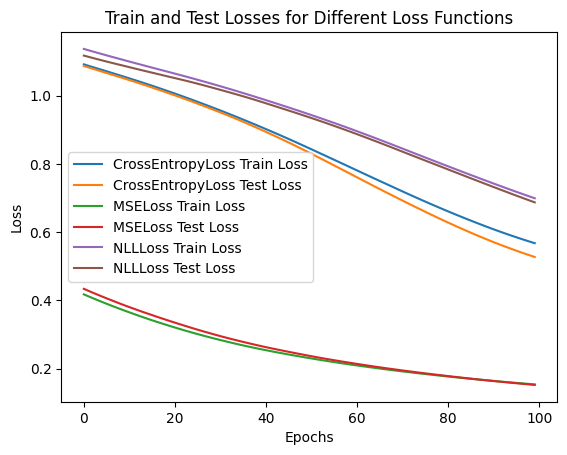

In [13]:
#Visualizar las pérdidas
for name in loss_functions.keys():
    plt.plot(all_train_losses[name], label=f'{name} Train Loss')
    plt.plot(all_test_losses[name], label=f'{name} Test Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses for Different Loss Functions')
plt.legend()
plt.show()

## Task 4 - Técnicas de Regularización

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Cargar el conjunto de datos de Iris
iris = load_iris()
X = iris.data
y = iris.target

# Escalar los datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

In [17]:
# Modelo
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [18]:
# Entrenar modelo de forma general
def train_model(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs=100):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validación
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())

    return train_losses, val_losses

In [19]:
input_size = X_train.shape[1]
hidden_size = 10
output_size = len(np.unique(y))
dropout_prob = 0.5
epochs = 100

### Entrenamiento con técnicas de regularización

In [20]:
# L1 Regularization (Lasso)
model_l1 = SimpleNN(input_size, hidden_size, output_size, dropout_prob)
criterion = nn.CrossEntropyLoss()
optimizer_l1 = optim.SGD(model_l1.parameters(), lr=0.01, weight_decay=0)

In [21]:
def l1_regularization(model, l1_lambda):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return l1_lambda * l1_norm

# train para incluir L1
def train_model_l1(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs=100, l1_lambda=0.01):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss += l1_regularization(model, l1_lambda)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validación
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())

    return train_losses, val_losses

# Entrenar el modelo con L1 regularization
train_losses_l1, val_losses_l1 = train_model_l1(model_l1, criterion, optimizer_l1, X_train, y_train, X_val, y_val, epochs=epochs)

In [22]:
# L2 Regularization (Ridge)
model_l2 = SimpleNN(input_size, hidden_size, output_size, dropout_prob)
optimizer_l2 = optim.SGD(model_l2.parameters(), lr=0.01, weight_decay=0.01)

# Entrenar el modelo con L2 regularization
train_losses_l2, val_losses_l2 = train_model(model_l2, criterion, optimizer_l2, X_train, y_train, X_val, y_val, epochs=epochs)

In [23]:
# Dropout
model_dropout = SimpleNN(input_size, hidden_size, output_size, dropout_prob)
optimizer_dropout = optim.SGD(model_dropout.parameters(), lr=0.01, weight_decay=0)

# Entrenar el modelo con Dropout
train_losses_dropout, val_losses_dropout = train_model(model_dropout, criterion, optimizer_dropout, X_train, y_train, X_val, y_val, epochs=epochs)

### Entrenamiento sin técnicas de regularización

In [24]:
# Sin regularización
model_no_reg = SimpleNN(input_size, hidden_size, output_size, dropout_prob=0)
optimizer_no_reg = optim.SGD(model_no_reg.parameters(), lr=0.01, weight_decay=0)

# Entrenar el modelo sin regularización
train_losses_no_reg, val_losses_no_reg = train_model(model_no_reg, criterion, optimizer_no_reg, X_train, y_train, X_val, y_val, epochs=epochs)

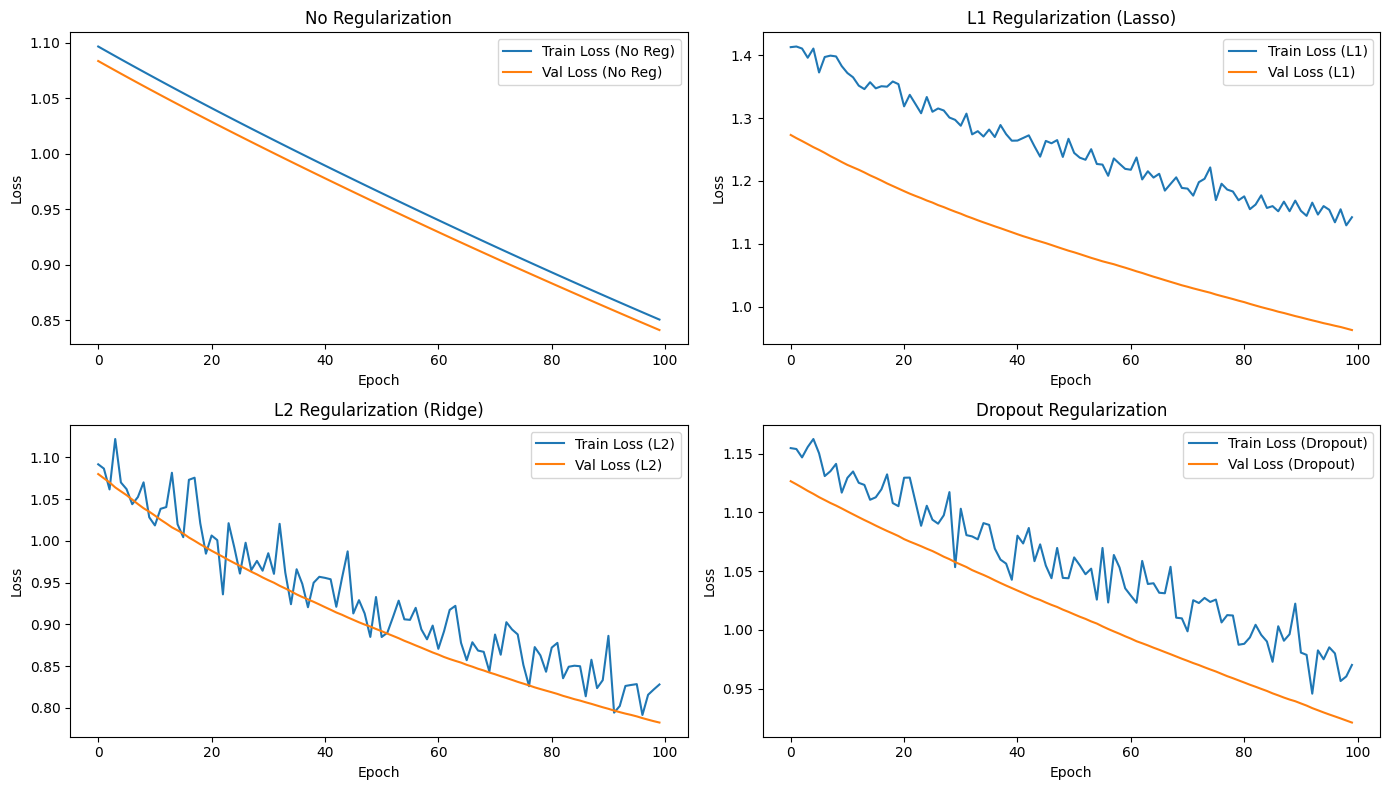

In [25]:
# Graficar las pérdidas de entrenamiento y validación
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(train_losses_no_reg, label='Train Loss (No Reg)')
plt.plot(val_losses_no_reg, label='Val Loss (No Reg)')
plt.title('No Regularization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_losses_l1, label='Train Loss (L1)')
plt.plot(val_losses_l1, label='Val Loss (L1)')
plt.title('L1 Regularization (Lasso)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_losses_l2, label='Train Loss (L2)')
plt.plot(val_losses_l2, label='Val Loss (L2)')
plt.title('L2 Regularization (Ridge)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_losses_dropout, label='Train Loss (Dropout)')
plt.plot(val_losses_dropout, label='Val Loss (Dropout)')
plt.title('Dropout Regularization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Análisis de resultados
- Sin Regularización: El modelo puede estar en riesgo de sobreajuste, ya que no hay mecanismos que controlen la complejidad del modelo.
- L1 Regularization: La esparsidad inducida por L1 ayuda a la generalización, pero puede introducir inestabilidad durante el entrenamiento.
- L2 Regularization: Proporciona un aprendizaje más estable y efectivo, equilibrando la reducción de la pérdida con un menor riesgo de sobreajuste.
- Dropout: Añade robustez contra el sobreajuste, a costa de introducir más variabilidad durante el entrenamiento, pero aún así mantiene una buena generalización.

## Task 5 - Algoritmos de Optimización

In [26]:
import time
from torch.utils.data import DataLoader, TensorDataset

# Entrenar el modelo y medir el tiempo de entrenamiento
def train_model_with_time(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs=100):
    train_losses = []
    val_losses = []
    start_time = time.time()
    
    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validación
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())
    
    end_time = time.time()
    training_time = end_time - start_time
    
    return train_losses, val_losses, training_time

In [27]:
# SGD (Stochastic Gradient Descent)
model_sgd = SimpleNN(input_size=X_train.shape[1], hidden_size=10, output_size=len(np.unique(y)), dropout_prob=0.5)
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)
train_losses_sgd, val_losses_sgd, time_sgd = train_model_with_time(model_sgd, nn.CrossEntropyLoss(), optimizer_sgd, X_train, y_train, X_val, y_val, epochs=100)

In [28]:
# Batch Gradient Descent
model_batch = SimpleNN(input_size=X_train.shape[1], hidden_size=10, output_size=len(np.unique(y)), dropout_prob=0.5)
optimizer_batch = optim.SGD(model_batch.parameters(), lr=0.01)
train_losses_batch, val_losses_batch, time_batch = train_model_with_time(model_batch, nn.CrossEntropyLoss(), optimizer_batch, X_train, y_train, X_val, y_val, epochs=100)

In [29]:
# Mini-Batch Gradient Descent
batch_size = 16
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [30]:
def train_model_minibatch(model, criterion, optimizer, train_loader, X_val, y_val, epochs=100):
    train_losses = []
    val_losses = []
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)

            # Ajustar el tipo de batch_y según el criterio de pérdida
            if isinstance(criterion, nn.CrossEntropyLoss):
                # clasificación
                loss = criterion(outputs, batch_y.long())
            else:
                # regresión
                loss = criterion(outputs, batch_y.float())

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        # Validación
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)

            # Ajustar el tipo de y_val según el criterio de pérdida
            if isinstance(criterion, nn.CrossEntropyLoss):
                # clasificación
                val_loss = criterion(val_outputs, y_val.long())
            else:
                # regresión
                val_loss = criterion(val_outputs, y_val.float())

            val_losses.append(val_loss.item())

    end_time = time.time()
    training_time = end_time - start_time

    return train_losses, val_losses, training_time

In [31]:
model_minibatch = SimpleNN(input_size=X_train.shape[1], hidden_size=10, output_size=len(np.unique(y)), dropout_prob=0.5)
optimizer_minibatch = optim.SGD(model_minibatch.parameters(), lr=0.01)
train_losses_minibatch, val_losses_minibatch, time_minibatch = train_model_minibatch(model_minibatch, nn.CrossEntropyLoss(), optimizer_minibatch, train_loader, X_val, y_val, epochs=100)

# Comparar los tiempos de entrenamiento y las pérdidas
(time_sgd, time_batch, time_minibatch)

(0.0413508415222168, 0.03550982475280762, 0.24132204055786133)

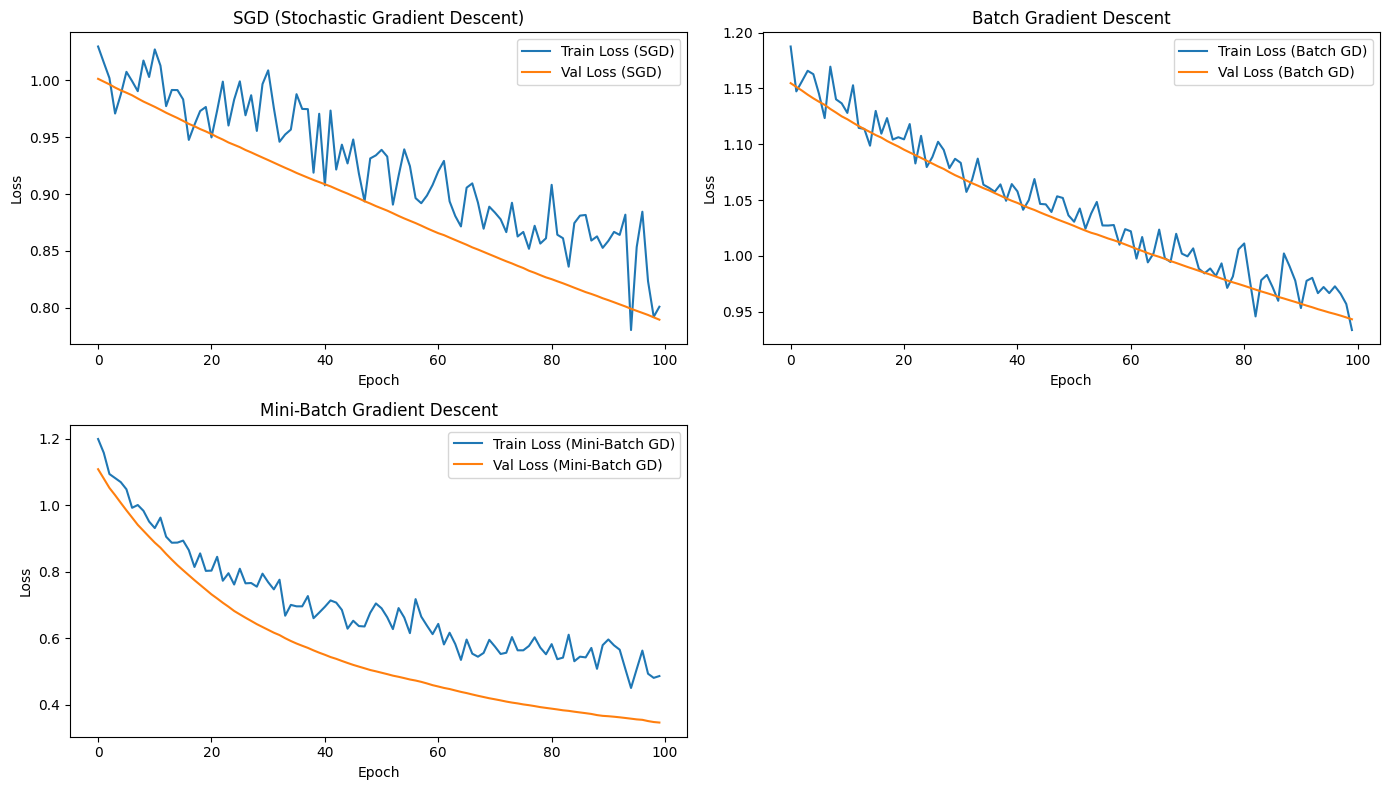

In [32]:
# Gráficas de las pérdidas de entrenamiento y validación para cada técnica de optimización
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(train_losses_sgd, label='Train Loss (SGD)')
plt.plot(val_losses_sgd, label='Val Loss (SGD)')
plt.title('SGD (Stochastic Gradient Descent)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_losses_batch, label='Train Loss (Batch GD)')
plt.plot(val_losses_batch, label='Val Loss (Batch GD)')
plt.title('Batch Gradient Descent')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_losses_minibatch, label='Train Loss (Mini-Batch GD)')
plt.plot(val_losses_minibatch, label='Val Loss (Mini-Batch GD)')
plt.title('Mini-Batch Gradient Descent')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Análisis de resultados
- SDG es el más rápido, pero tiene fluctuaciones en las pérdidas, lo que puede hacer que la convergencia sea menos predecible.
- Batch GD es un ligeramente más lento que SGD, pero tiene una convergencia más estable .
- Mini-Batch GD es el más lento de los tres, tiene más estabilidad y velocidad de convergencia.

## Task 6 - Experimentación y Análisis

In [33]:
# Lista para almacenar resultados
results = []

def train_model_l1(model, criterion, optimizer, X_train, y_train, X_val, y_val, epochs=100, l1_lambda=0.01):
    train_losses = []
    val_losses = []
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss += l1_regularization(model, l1_lambda)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())
    
    end_time = time.time()
    # Calcular el tiempo de entrenamiento
    training_time = end_time - start_time

    return train_losses, val_losses, training_time

In [34]:
# SGD + Dropout + CrossEntropyLoss
model_sgd = SimpleNN(input_size=X_train.shape[1], hidden_size=10, output_size=len(np.unique(y)), dropout_prob=0.5)
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)
train_losses_sgd, val_losses_sgd, time_sgd = train_model_with_time(model_sgd, nn.CrossEntropyLoss(), optimizer_sgd, X_train, y_train, X_val, y_val, epochs=100)
results.append(('SGD + Dropout + CrossEntropy', train_losses_sgd, val_losses_sgd, time_sgd))

In [35]:
# Batch GD + Dropout + CrossEntropyLoss
model_batch = SimpleNN(input_size=X_train.shape[1], hidden_size=10, output_size=len(np.unique(y)), dropout_prob=0.5)
optimizer_batch = optim.SGD(model_batch.parameters(), lr=0.01)
train_losses_batch, val_losses_batch, time_batch = train_model_with_time(model_batch, nn.CrossEntropyLoss(), optimizer_batch, X_train, y_train, X_val, y_val, epochs=100)
results.append(('Batch GD + Dropout + CrossEntropy', train_losses_batch, val_losses_batch, time_batch))

In [36]:
# Mini-Batch GD + Dropout + CrossEntropyLoss
batch_size = 16
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model_minibatch = SimpleNN(input_size=X_train.shape[1], hidden_size=10, output_size=len(np.unique(y)), dropout_prob=0.5)
optimizer_minibatch = optim.SGD(model_minibatch.parameters(), lr=0.01)
train_losses_minibatch, val_losses_minibatch, time_minibatch = train_model_minibatch(model_minibatch, nn.CrossEntropyLoss(), optimizer_minibatch, train_loader, X_val, y_val, epochs=100)
results.append(('Mini-Batch GD + Dropout + CrossEntropy', train_losses_minibatch, val_losses_minibatch, time_minibatch))

In [37]:
# SGD + Dropout + MSELoss
model_sgd_mse = SimpleNN(input_size=X_train.shape[1], hidden_size=10, output_size=1, dropout_prob=0.5)
optimizer_sgd_mse = optim.SGD(model_sgd_mse.parameters(), lr=0.01)
train_losses_sgd_mse, val_losses_sgd_mse, time_sgd_mse = train_model_with_time(model_sgd_mse, nn.MSELoss(), optimizer_sgd_mse, X_train, y_train.float(), X_val, y_val.float(), epochs=100)
results.append(('SGD + Dropout + MSE', train_losses_sgd_mse, val_losses_sgd_mse, time_sgd_mse))

/Users/melissa/Desktop/UVG/deepLearning/DL-HDT-02/myenv/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([120])) that is different to the input size (torch.Size([120, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/melissa/Desktop/UVG/deepLearning/DL-HDT-02/myenv/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [38]:
# Batch GD + Dropout + MSELoss
model_batch_mse = SimpleNN(input_size=X_train.shape[1], hidden_size=10, output_size=1, dropout_prob=0.5)
optimizer_batch_mse = optim.SGD(model_batch_mse.parameters(), lr=0.01)
train_losses_batch_mse, val_losses_batch_mse, time_batch_mse = train_model_with_time(model_batch_mse, nn.MSELoss(), optimizer_batch_mse, X_train, y_train.float(), X_val, y_val.float(), epochs=100)
results.append(('Batch GD + Dropout + MSE', train_losses_batch_mse, val_losses_batch_mse, time_batch_mse))

In [39]:
# Batch GD + Dropout + MSELoss
model_minibatch_mse = SimpleNN(input_size=X_train.shape[1], hidden_size=10, output_size=1, dropout_prob=0.5)
optimizer_minibatch_mse = optim.SGD(model_minibatch_mse.parameters(), lr=0.01)
train_losses_minibatch_mse, val_losses_minibatch_mse, time_minibatch_mse = train_model_minibatch(model_minibatch_mse, nn.MSELoss(), optimizer_minibatch_mse, train_loader, X_val, y_val.float(), epochs=100)
results.append(('Mini-Batch GD + Dropout + MSE', train_losses_minibatch_mse, val_losses_minibatch_mse, time_minibatch_mse))

/Users/melissa/Desktop/UVG/deepLearning/DL-HDT-02/myenv/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/melissa/Desktop/UVG/deepLearning/DL-HDT-02/myenv/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [40]:
# SGD + L1 + CrossEntropyLoss (continuación)
model_minibatch_mse = SimpleNN(input_size=X_train.shape[1], hidden_size=10, output_size=1, dropout_prob=0.5)
optimizer_minibatch_mse = optim.SGD(model_minibatch_mse.parameters(), lr=0.01)
train_losses_minibatch_mse, val_losses_minibatch_mse, time_minibatch_mse = train_model_minibatch(model_minibatch_mse, nn.MSELoss(), optimizer_minibatch_mse, train_loader, X_val, y_val.float(), epochs=100)
results.append(('Mini-Batch GD + Dropout + MSE', train_losses_minibatch_mse, val_losses_minibatch_mse, time_minibatch_mse))

In [41]:
# SGD + L2 + CrossEntropyLoss
model_l2 = SimpleNN(input_size=X_train.shape[1], hidden_size=10, output_size=len(np.unique(y)), dropout_prob=0.5)
optimizer_l2 = optim.SGD(model_l2.parameters(), lr=0.01, weight_decay=0.01)

train_losses_l2, val_losses_l2, time_l2 = train_model_with_time(model_l2, nn.CrossEntropyLoss(), optimizer_l2, X_train, y_train, X_val, y_val, epochs=100)
results.append(('SGD + L2 + CrossEntropy', train_losses_l2, val_losses_l2, time_l2))

In [42]:
# SGD + Sin Regularización + CrossEntropyLoss
model_no_reg = SimpleNN(input_size=X_train.shape[1], hidden_size=10, output_size=len(np.unique(y)), dropout_prob=0)
optimizer_no_reg = optim.SGD(model_no_reg.parameters(), lr=0.01, weight_decay=0)

train_losses_no_reg, val_losses_no_reg, time_no_reg = train_model_with_time(model_no_reg, nn.CrossEntropyLoss(), optimizer_no_reg, X_train, y_train, X_val, y_val, epochs=100)
results.append(('SGD + Sin Regularización + CrossEntropy', train_losses_no_reg, val_losses_no_reg, time_no_reg))

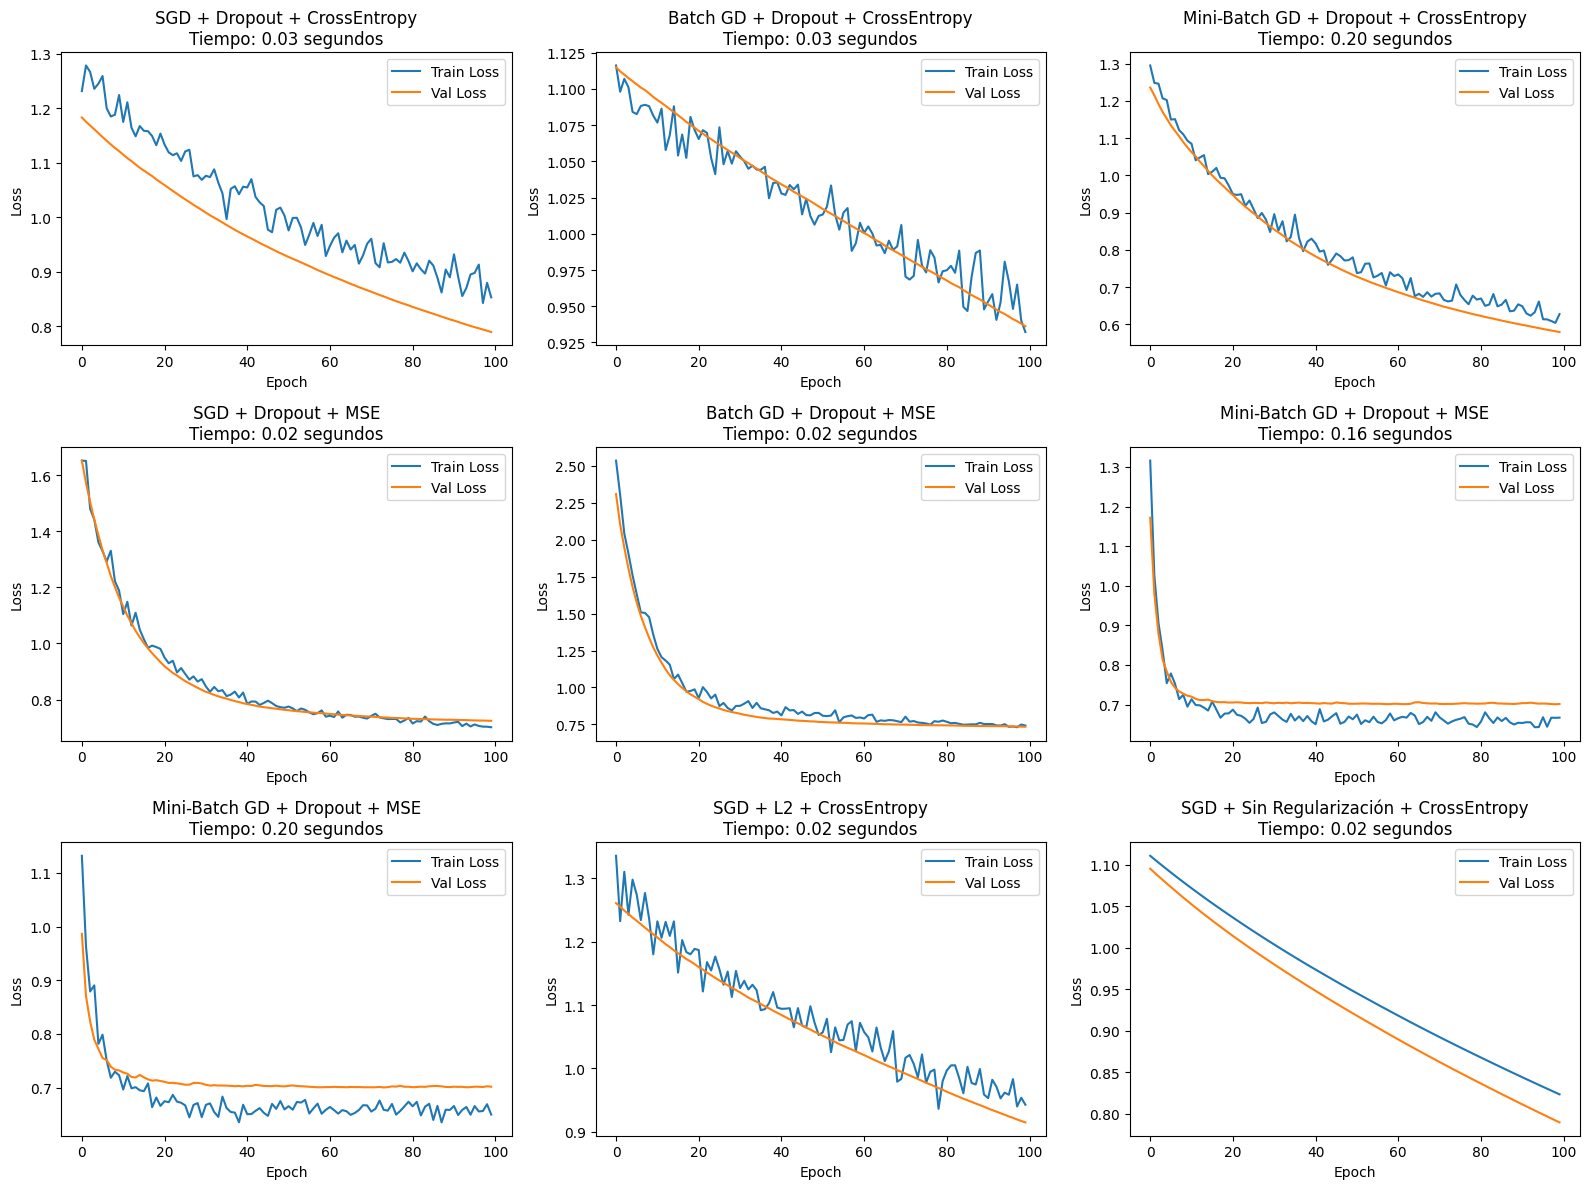

In [43]:
# Resultados
plt.figure(figsize=(16, 12))

for i, (label, train_loss, val_loss, train_time) in enumerate(results):
    plt.subplot(3, 3, i+1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title(f'{label}\nTiempo: {train_time:.2f} segundos')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()

## Task 7 - Discusión

Comparando la **velocidad de convergencia** en las combinaciones de los **algoritmos**, cuando se utiliza `SDG` se tiene un rendimiento final aceptable pero no siempre tan estable como otros métodos por sus fluctuaciones. `Batch GD` tiene un rendimiento consistente y estable lo que lo hace ideal en situaciones donde la estabilidad es más importante que la velocidad de convergencia. `Mini-Batch GD` tiene rapidez de convergencia y rendimiento final bastante aceptable, por lo que se le puede considerar un modelo que generaliza bien.

Por otro lado, comparando el **rendimiento final** de las **funciones de pérdida**, usando `CrossEntropyLoss` nos indica que es la adecuada para tareas de clasificación mostrando un rendimiento robusto cuando se combina con técnicas de regularización como Dropout o L2. `MSELoss` funciona bien para regresión, logrando un rendimiento sólido cuando se utiliza con Mini-Batch GD. 

Con respecto a las **técnicas de regularización**, `Dropout` introduce ruido durante el entrenamiento pero mejora la generalización al reducir el sobreajuste, en especial al usarse con SGD o Mini-Batch GD. `Regularización L2` ayuda a una convergencia más suave mejorando la capacidad del modelo para generalizar a nuevos datos reduciendo el sobreajuste. `Sin Regularización` lleva a una convergencia rápida y aumenta el riesgo del sobreajuste lo que implica un rendimiento final bastante bajo en datos de validación.

Lo anterior brinda espacio al por qué ciertas técnicas conducen a un mejor rendimiento y esto depende del tipo de análisis que se vaya a realizar. Las ténicas de regularización Dropout y L2 son vitales para evitar el sobreajuste, la selección de una función de pérdida depende de la tarea sea clasificación o regresión. En cuanto a los algoritmos, Mini-Batch GD ofrece una buena estabilidad y eficiencia en términos de entrenamiento. Las combinaciones entre ellas afectan tanto la velocidad de convergencia como el rendimiento final del modelo, por lo que es importante saber el propósito del modelo para elegir las mejores opciones.

# Ejercicio 2

El objetivo de esta parte es repasar los fundamentos teóricos de Transformers y Attention. Para ello lea el paper [Attention is All You Need](https://arxiv.org/pdf/1706.03762). Luego responda las siguientes preguntas:


#### 1. ¿Cuál es la principal innovación de la arquitectura Transformer?
#### 2. ¿Cómo funciona el mecanismo de atención del scaled dot-product?
#### 3. ¿Por qué se utiliza la atención de múltiples cabezales en Transformer?
#### 4. ¿Cómo se incorporan los positional encodings en el modelo Transformer?
#### 5. ¿Cuáles son algunas aplicaciones de la arquitectura Transformer más allá de la machine translation?